#                             EPOCH TASK-1

### Importing the necessary libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plts
import geopandas as gpd
import re
from shapely.geometry import Point
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

### Reading the data

In [18]:
data = pd.read_csv('clustering_data.csv',dtype={
        'CircleName':'string',
        'RegionName':'string',
        'DivisionName':'string',
        'OfficeName':'string',
        'Pincode':'int64',
        'OfficeType':'string',
        'Delivery':'string',
        'District':'string',
        'StateName':'string',
        'Latitude':'string',
        'Longitude':'string'
})
data.shape

(157126, 11)

### Filtering the data 

*Since I reside in Telanagana,I am filtering Telangana data out*

In [19]:
data=data.dropna(axis=0,how='any')
data=data[data['StateName']=='TELANGANA']
data.shape

(4281, 11)

*Just in case if the latitudes or longitdes contain any characters like E,N*

In [20]:

def separate_number_letter(value):
    match = re.match(r"([0-9.]+)([A-Za-z]+)", value)
    if match:
        return match.group(1), match.group(2)
    return value, None
#--> This seperates the character from the latitudes and longitudes
data[['Latitude_number', 'Latitude_letter']] = data['Latitude'].apply(lambda x: pd.Series(separate_number_letter(x)))
data[['Longitude_number', 'Longitude_letter']] = data['Longitude'].apply(lambda x: pd.Series(separate_number_letter(x)))

### Plotting the filtered out data 

In [21]:
fig = px.scatter(data,x='Longitude_number',y='Latitude_number')
fig.show()



*Some necessary cleanings*

In [22]:
data['Longitude_number']=data['Longitude_number'].astype(float)
data['Latitude_number']=data['Latitude_number'].astype(float)
data = (data[data['Latitude']<='20'])
data = (data[data['Latitude']>='15.5'])
data = (data[data['Longitude']<='82'])
data = (data[data['Longitude']>='77'])
#--> To ensure the filtered data is in Telagana itself

### ELBOW METHOD

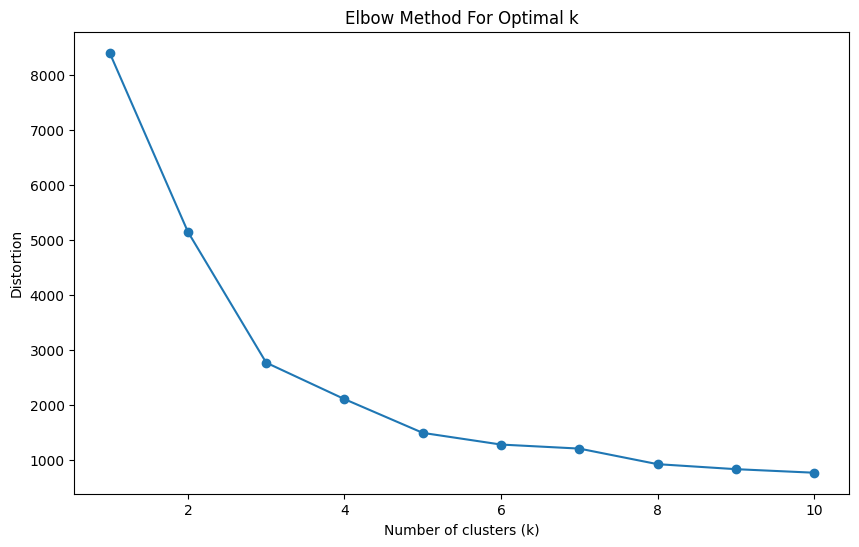

In [23]:
X = data[['Longitude','Latitude',]].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def elbow_method(X):
    distortions = []
    # Testing k value for only values from 1 to 10 as we know as the value of k increases slope almost becomes 0.So it only makes sense from 1 to 10
     
    for k in range(1, 11) :
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_) 

    # Plot the elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11) , distortions, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method For Optimal k')
    plt.show()

elbow_method(X_scaled)
# From the below graph we can consider 3 as the optimal number of clusters

### KMEANS CLUSTERING FROM SCRATCH

In [24]:
def euclidean_distance(p1, p2):
    """Calculates the Euclidean distance between two points."""
    if isinstance(p1, str) or isinstance(p2, str):
        raise ValueError("euclidean_distance expects numerical data points")
    return np.linalg.norm(np.array(p1, dtype=float) - np.array(p2, dtype=float))

k = 3

class K_Means:
    def __init__(self,k=3,max_iter=300,tol=0.001) :
        self.k=3
        self.tol=tol
        self.max_iter=max_iter
        self.centroids = {}
        self.cluster_labels_ =[]
    
    def fit(self,data):
        
        self.centroids={}

        for i in range(self.k):
            self.centroids[i]=data[np.random.choice(len(data))]

        prev_centroids={}
        iterations =0 

        #If the assigned clusters are not changing significantly for the data points,we can stop the algorithm for efficiency 
        while iterations<self.max_iter and not self._no_significant_change(prev_centroids):
            iterations += 1
            prev_centroids=self.centroids.copy()

            # Assign data points to closest centroids
            clusters = {} # initialising a empty dictionary 
            for i in range(self.k):
                self.cluster_labels_ = [] # initialisng a cluster dictionary values to be a empty list 

            for point in data:
                min_distance = float('inf') #--> Basic thing to do while computing the min value
                optimal_centroid = None
                for centroid_id, centroid in self.centroids.items():
                    distance = euclidean_distance(point, centroid)
                    if distance < min_distance:
                        min_distance = distance
                        optimal_centroid = centroid_id #--> centroid_id is some kind of label for the clusters
                 #--> We are appending the point to the dictionary cluster with the key as optimal_centroid
                self.cluster_labels_.append(optimal_centroid)


            #Reassigning the centroids to the mean of all the points in the cluster
            for centroid_id,points in clusters.items():
                new_centroid=np.mean(points,axis=0)
                self.centroids[centroid_id]=np.mean(points, axis=0)
                #Here we are reassigning the centroids to the mean of the points in that centroid_id i.e, one of the cluster

        self.cluster_centers_ = self.centroids.copy()
        return self.cluster_labels_
               
    def _no_significant_change(self,prev_centroids):
        if prev_centroids is None or len(prev_centroids) == 0:
            return False
        for centroid_id, new_centroid in self.centroids.items():
            if np.linalg.norm(prev_centroids[centroid_id] - new_centroid) > self.tol:
                return False
        return True
    

*Implementing the kmeans clustering classs*

In [25]:
final_data=np.array([data['Longitude_number'],data['Latitude_number']])
final_data=final_data.transpose()
kmeans=K_Means(k=3)
cluster_labels=kmeans.fit(final_data)
centroids = list(kmeans.centroids.values())

### Visual Representation of the clusters formed

In [27]:
# Defining colorscale for 3 clusters
colorscale = ['red', 'yellow', 'blue']
centroid_colors = [colorscale[cluster_id] for cluster_id in range(len(centroids))]
# Create scatter plots for data and centroids
data = [
  go.Scatter(
      x=final_data[:, 0],
      y=final_data[:, 1],
      mode='markers',
      marker=dict(color=[colorscale[label] for label in cluster_labels], size=2)
  ),
  go.Scatter(
      x=[centroid[0] for centroid in centroids],
      y=[centroid[1] for centroid in centroids],
      mode='markers',
      marker=dict(color='black', size=6 ,symbol=8)
  )
]

# Configure layout
layout = go.Layout(
    title='KMeans Clustering with 3 Clusters',
    xaxis_title='Latitude',
    yaxis_title='Longitude',
)
# Create figure and display it
fig = go.Figure(data=data, layout=layout ,layout_yaxis_range=[15.5,20],layout_xaxis_range=[77,82] )
fig.update_layout(
    margin=dict(l=20, r=20, t=50, b=20),
    paper_bgcolor="LightSteelBlue",
    width=600, height=400,showlegend=False
)
fig.show()


### *Insights:*  
##### 1. Data Filtering:

The dataset contains various pincodes across India with corresponding longitudes and latitudes.
We specifically focus on filtering out entries that belong to the state of Telangana.
This involves selecting rows where the 'StateName' column matches 'TELANGANA'.

##### 2. Data Cleaning:

Latitude and Longitude values must be numeric. Non-numeric values are handled by coercing them to NaN and then removing such entries.
Ensuring clean data helps in accurately plotting the geographical locations.

##### 3. Data Visualization:

Utilizing the longitude and latitude data to plot the geographical locations of the pincodes on a map provides a visual representation of the distribution.
A base map of India is used, highlighting the geographical context of the pincodes in Telangana.
The visualization can reveal patterns, such as clusters of pincodes in certain regions, which might indicate population centers or areas of higher postal service activity.


### *Conclusions:*
##### 1. Geographical Distribution:

The plotted map shows the spatial distribution of pincodes within Telangana.
Areas with dense clusters of pincodes likely correspond to urban centers, while sparse areas might indicate rural regions.
    
##### 2. Utility of Visualization:

Visualizing the data helps in understanding the geographical spread and can be useful for various applications, such as planning logistics, optimizing postal services, and market analysis.
It provides a clear, immediate insight that can be more informative than raw data tables.
Data Accuracy and Completeness:

The accuracy of the plotted points depends on the quality of the longitude and latitude data.
Any gaps or inaccuracies in the dataset can affect the visualization, emphasizing the need for clean and complete data.

Potential Extensions:

Additional layers of data, such as population density or infrastructure, can be added to the map for more comprehensive insights.